In [37]:
%matplotlib inline
import pandas as pd 
import numpy as np 
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.preprocessing import StandardScaler as StandardScale
from collections import Counter

In [3]:
df = pd.read_csv('capture20110811.pcap.netflow.labeled', sep ='\s+')
df.head()

,#Date_flow,start,Durat,Prot,Src_IP_Addr:Port,->,Dst_IP_Addr:Port,Flags,Tos,Packets,Bytes,Flows,Label(LEGITIMATE:Botnet:Background)
0,2011-08-11,10:10:00.003,0.967,UDP,89.31.8.11:23929,->,147.32.84.229:13363,INT,0,2,135,1,Background
1,2011-08-11,10:10:00.003,0.967,UDP,147.32.84.229:13363,->,89.31.8.11:23929,INT,0,2,276,1,Background
2,2011-08-11,10:10:00.006,0.000,UDP,208.88.186.6:34042,->,147.32.84.229:13363,INT,0,1,62,1,Background
3,2011-08-11,10:10:00.008,0.000,UDP,92.118.218.77:55246,->,147.32.84.229:13363,INT,0,1,78,1,Background
4,2011-08-11,10:10:00.009,0.000,UDP,182.185.139.181:10223,->,147.32.84.229:13363,INT,0,1,72,1,Background


In [4]:
df['Label'] =  df['Label(LEGITIMATE:Botnet:Background)']
df[['Src_IP', 'Src_Port']] = df['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
df[['Dst_IP', 'Dst_Port']] = df['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)
df = df.drop(labels=[ '->', 'Label(LEGITIMATE:Botnet:Background)', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1)


In [5]:
#df = df[~df.Label.str.contains("Background", na=False)]
df_clean = df[ df['Label'] != 'Background' ]

len(df[df['Label'] == 'Botnet'])

54433

In [7]:
print(df_clean.shape)
print(len(df[df['Label'] == 'Botnet']))
df_clean.head()


(279769, 14)
54433


,#Date_flow,start,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP,Src_Port,Dst_IP,Dst_Port
37,2011-08-11,10:10:00.106,1.915,TCP,FSPA_,0,10,2334,1,LEGITIMATE,147.32.85.76,2550,74.125.232.198,443
39,2011-08-11,10:10:00.114,1.901,TCP,_FSPA,0,7,3011,1,LEGITIMATE,147.32.85.76,2550,74.125.232.198,443
75,2011-08-11,10:10:00.208,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.84.59,59485,74.125.232.213,443
229,2011-08-11,10:10:00.613,0.000,TCP,A_,0,2,132,1,LEGITIMATE,147.32.84.59,54163,74.125.232.203,443
245,2011-08-11,10:10:00.666,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.85.5,33087,74.125.232.213,443


In [47]:
infected_IP = '147.32.84.165'
#cardid over month 
df_1 = df_clean[['Src_IP','Src_Port']]
card_month = df_1.groupby(['Src_Port'], as_index=False)


AttributeError: Cannot access attribute 'values' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [39]:
src_ip = df.groupby(['Src_IP'])
#print(src_ip.size())
num_of_src_ports = df['Src_Port'].value_counts()
#print(num_of_src_ports)
num_dst_ports = df['Dst_Port'].value_counts()

uni = df['Dst_Port'].unique()
num_unique_src_ports = Counter(uni)
print(num_unique_src_ports )



Counter({'13363': 1, '23929': 1, '55246': 1, '10223': 1, '6386': 1, '64117': 1, '16723': 1, '38574': 1, '62268': 1, '6112': 1, '58283': 1, '21586': 1, '22': 1, '4845': 1, '10012': 1, '7750': 1, '14787': 1, '50664': 1, '58309': 1, '443': 1, '14098': 1, '15632': 1, '62111': 1, '54364': 1, '48808': 1, None: 1, '5222': 1, '31404': 1, '54254': 1, '42966': 1, '51523': 1, '59659': 1, '33330': 1, '55826': 1, '34054': 1, '24106': 1, '42256': 1, '33033': 1, '38413': 1, '57271': 1, '31518': 1, '9999': 1, '59485': 1, '49177': 1, '45052': 1, '51645': 1, '13140': 1, '4147': 1, '34792': 1, '44297': 1, '80': 1, '1386': 1, '1387': 1, '63144': 1, '59419': 1, '27123': 1, '50928': 1, '38064': 1, '4048': 1, '53': 1, '2089': 1, '33102': 1, '39656': 1, '46178': 1, '41234': 1, '65083': 1, '52174': 1, '55563': 1, '161': 1, '54524': 1, '1895': 1, '61903': 1, '12902': 1, '59696': 1, '43120': 1, '60451': 1, '60936': 1, '10010': 1, '3244': 1, '53719': 1, '53595': 1, '35068': 1, '15164': 1, '6881': 1, '42529': 1, '

In [ ]:

    unique_src_ports = src_ip['Sport'].unique()
   


In [8]:
label_mapping={}
label_mapping['Label'] = {'LEGITIMATE': 0, 'Botnet' : 1}
df_clean.replace({'Label' : label_mapping['Label']}, inplace=True)

C:\Users\konch\Anaconda3\lib\site-packages\pandas\core\generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [83]:
y =df_clean['Label'].values
print(y)

[0 0 0 ... 0 0 0]


In [84]:
char_cols = df_clean.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    df_clean[c], label_mapping[c] = pd.factorize(df_clean[c])

C:\Users\konch\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
X = df_clean.drop(['Label'], axis = 1).values

print("Dataset shape: ", X.shape)

Dataset shape:  (279769, 13)


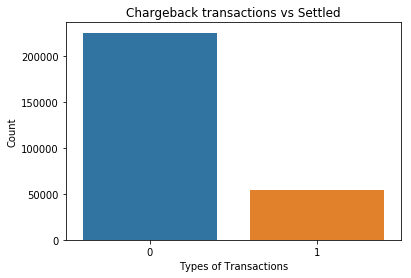

In [86]:
ax = df_clean['Label'].value_counts()
plt.title('Chargeback transactions vs Settled')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Transactions')
plt.ylabel('Count')
plt.show()


In [87]:
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

In [88]:
def roc_analysis(X, y, clf, cv, plot_all_ROC, plot_ROC, plot_cm, normalize_cm, sm = None):

        # vectors for storing True Positives, False Negatives, False Positives and True negatives
        # respectively per cross-validation run
        num_splits = cv.get_n_splits()
        TP = np.zeros(num_splits, dtype = int)
        FN = np.zeros_like(TP)
        FP = np.zeros_like(TP)
        TN = np.zeros_like(TP)

        # Likewise for storing precision, recall and F1 score respectively extracted,
        # per cross-validation run
        PR = np.zeros(num_splits)
        R = np.zeros_like(PR)
        F1 = np.zeros_like(PR)

        # Likewise for the True Positive Rate and the Area Under Curve
        TPR = []
        AUC = []
        mean_FPR = np.linspace(0,1,100)



        i = 0
        if plot_ROC:
            plt.figure(figsize = (8, 10))

        # Cross-validation
        for train_index, test_index in cv.split(X, y):
            # If sm is provided, after extracting the split we first perform SMOTE on
            # training data and then proceed to training the classifier
            if sm != None:
                X_train, y_train = sm.fit_resample(X[train_index], y[train_index])
            else:
                X_train, y_train = X[train_index], y[train_index]

            # Train the classifier and extract predictions for test samples
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X[test_index])

            # Uncomment following lines in case you want to see number of TP,FP,TN,FN per run
            # print("num TP: ", np.sum(np.logical_and(y_pred == 1, y[test_index] == 1)))
            # print("num FP: ", np.sum(np.logical_and(y_pred ==1, y[test_index] == 0)))
            # print("num TN: ", np.sum(np.logical_and(y_pred == 0, y[test_index] == 0)))
            # print("num FN: ", np.sum(np.logical_and(y_pred == 0, y[test_index] == 1)))

            # Extract confusion matrix, precision, recall and F1 score for the current
            # run of cross validatin
            TN[i], FP[i], FN[i], TP[i] = confusion_matrix(y[test_index], y_pred).ravel()
            PR[i] = precision_score(y[test_index], y_pred, average = 'binary')
            R[i] = recall_score(y[test_index], y_pred, average = 'binary')
            F1[i] = f1_score(y[test_index], y_pred, average = 'binary')

            # Extract false positive and true positive rate correspoding to the positive (fraud) label
            fpr, tpr, thresholds = roc_curve(y[test_index], clf.predict_proba(X[test_index])[:, 1])

            # Interpolate extracted values on range of 0:100 with a step of 1
            TPR.append(np.interp(mean_FPR, fpr, tpr))

            # Set the first value of the run equal to 0
            TPR[-1][0] = 0.0

            # Extract and append to list the Area under Curve
            roc_auc = auc(fpr, tpr)
            AUC.append(roc_auc)

            # if TRUE all ROC curves correspodning to each run are plotted
            if plot_all_ROC:
                plt.plot(fpr, tpr, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i = i+1

        # Extract mean values and standard deviations per run
        mean_TPR = np.mean(TPR, 0)
        mean_TPR[-1] = 1.0
        std_TPR = np.std(TPR, 0)
        # To assure that it doesn't go out of the graph
        upper_TPR = np.minimum(mean_TPR + std_TPR, 1)
        lower_TPR = np.maximum(mean_TPR - std_TPR, 0)

        mean_AUC = auc(mean_FPR, mean_TPR)
        std_AUC = np.std(AUC)

        mean_PR = np.mean(PR)
        mean_R = np.mean(R)
        mean_F1 = np.mean(F1)
        std_F1 = np.std(F1)

        # If true plot the mean ROC curve
        if plot_ROC:
            # Line corresponding to the 'Chance' classifier (50-50)
            plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
                 label='Chance', alpha=.8)

            plt.plot(mean_FPR, mean_TPR, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_AUC, std_AUC),
                 lw=2, alpha=.8)
            plt.fill_between(mean_FPR, lower_TPR, upper_TPR, color='b', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic curve')
            plt.legend(loc="lower right")
            plt.show()

        # Extract the overall confusion matrix, by summing up the values extracted
        # from all runs.
        cm = np.array([np.sum(TN), np.sum(FP), np.sum(FN), np.sum(TP)])
        cm = np.reshape(cm, [2,2], order='C')

        # If TRUE, Plot confusion matrix
        if plot_cm:
            plt.figure()
            plot_confusion_matrix(cm, classes = ['Non-Fraud', 'Fraud'], normalize = normalize_cm)

        return mean_TPR, std_TPR, mean_AUC, std_AUC, mean_F1, std_F1, cm

In [65]:
print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

Fraud class samples:  530889
Non-fraud class samples:  1251502
Ratio:  0.42420147950223014


In [91]:
import numpy as np
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score


# Inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# This function plots the confusion matrix.
#
# INPUT:
#    cm        : confusion matrix to be printed (in form of a 2x2 matrix),
#    classes   : the labels corresponding to the classes (in our case 'Settled' and 'Chargeback')
#    normalize : whether to present normalized counts or not,
#    title     : title of the provided plot,
#    cmap      : the color map used for the visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


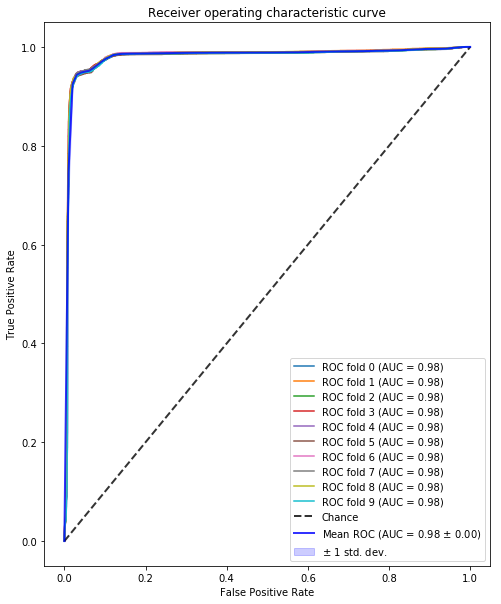

Confusion matrix, without normalization
[[180224  45112]
 [   723  53710]]


<Figure size 432x288 with 0 Axes>

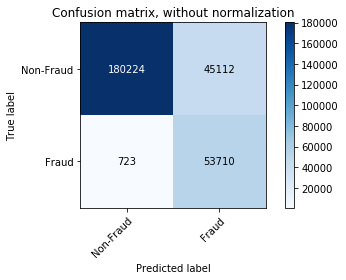

In [92]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

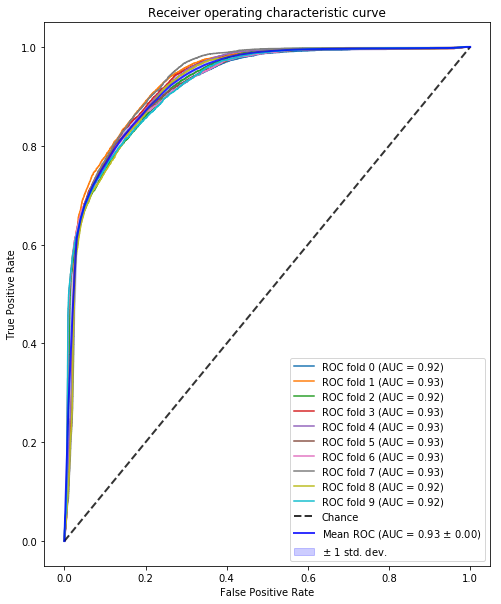

Confusion matrix, without normalization
[[207960  17376]
 [ 14755  39678]]


<Figure size 432x288 with 0 Axes>

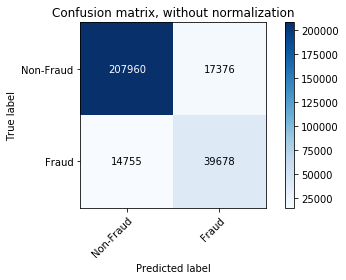

In [93]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\konch\Anacond

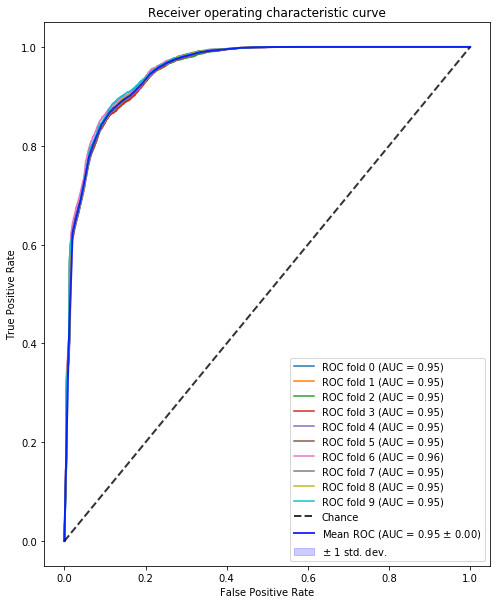

Confusion matrix, without normalization
[[215220  10116]
 [ 15926  38507]]


<Figure size 432x288 with 0 Axes>

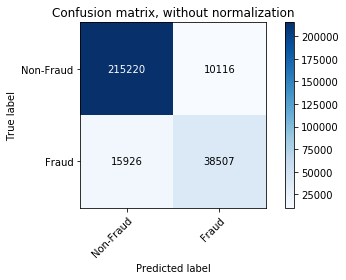

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
lda_mean_tpr, lda_std_tpr, lda_mean_auc, lda_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

C:\Users\konch\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


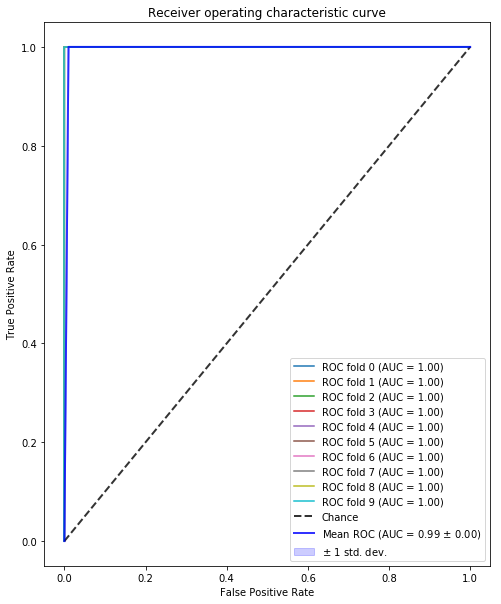

Confusion matrix, without normalization
[[225330      6]
 [     3  54430]]


<Figure size 432x288 with 0 Axes>

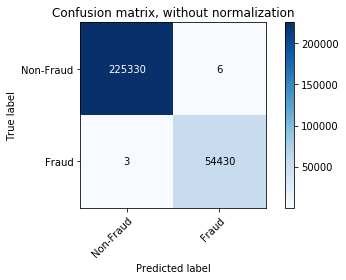

In [95]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)